# 安裝相關套件

In [0]:
!pip install --upgrade torch
!pip install torchaudio

     |████████████████████████████████| 748.9MB 16kB/s 
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
     |████████████████████████████████| 2.6MB 4.8MB/s 


# 載入相關套件

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchaudio

from IPython.display import Audio

%matplotlib inline
import matplotlib.pyplot as plt

torch.manual_seed(26)

# Acoustic Feature

### 下載語音檔案

In [0]:
!rm *.wav
!wget https://raw.githubusercontent.com/samsungsds-rnd/deepspeech.mxnet/master/Libri_sample/3830-12529-0005.wav -O "sample.wav"

rm: cannot remove '*.wav': No such file or directory
--2019-08-13 07:16:24--  https://raw.githubusercontent.com/samsungsds-rnd/deepspeech.mxnet/master/Libri_sample/3830-12529-0005.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126158 (123K) [audio/wav]
Saving to: ‘sample.wav’

sample.wav          100%[===================>] 123.20K  --.-KB/s    in 0.02s   

2019-08-13 07:16:24 (5.58 MB/s) - ‘sample.wav’ saved [126158/126158]



### 讀取檔案

Shape of waveform: torch.Size([1, 63040])
Sample rate: 16000


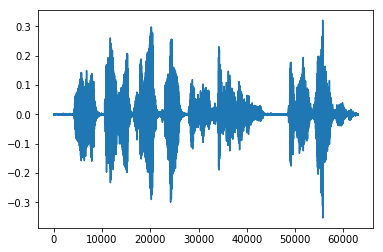

In [0]:
waveform, sample_rate = torchaudio.load("sample.wav")

plt.figure()
plt.plot(waveform.t().numpy())

print("Shape of waveform:", waveform.shape)
print("Sample rate:", sample_rate)

### 聽聽看吧 ，請帶耳機

In [0]:
transcript = "WE WERE ABLE TO IMPART THE INFORMATION THAT WE WANTED"
Audio(waveform.numpy(), rate=sample_rate)

### 畫看看剛剛提到的 Spectrogram

Shape of spectrogram: torch.Size([1, 201, 316])


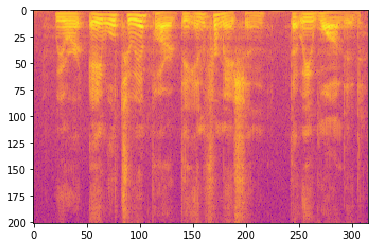

In [0]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap="plasma")

### 抽取 acoustic feature filter bank

In [0]:
x = torchaudio.compliance.kaldi.fbank(waveform,
                                      frame_length=25.0, # 一個 frame 幾毫秒
                                      frame_shift=10.0,  # 每隔幾毫秒做一 frame
                                      num_mel_bins=80).unsqueeze(0)

print("Shape of acoustic feature x:", x.shape)
# 392 ~= waveform.shape[1] / sample_rate / frame_shift

Shape of acoustic feature x: torch.Size([1, 392, 80])


## 恭喜你已經會抽 acoustic feature 了！！！！！

# Encoder

### 調用 nn.LSTM

In [0]:
encoder = nn.LSTM(input_size=80,       # acoustic feature 的維度也就是上面定義的 num_mel_bins
                  hidden_size=320,     # rnn hidden state 的維度
                  num_layers=5,        # 要疊幾層 rnn
                  bidirectional=True,  # 啟用雙向 rnn
                  batch_first=True)

### 把 acoustic feature x 丟進 encoder 產生 h

In [0]:
h, enc_state = encoder(x)
print("Shape of encoder outputs h:", h.shape)
# 因為是 bidrectional 的，PyTorch 會把兩個方向的 output 接在一起
# 因此最後一個維度 640 = 320 * 2

Shape of encoder outputs h: torch.Size([1, 392, 640])


## 恭喜你已經會寫 encoder 惹！！！！！

# Attention

### 將 attention 包裝成一個 class

In [0]:
class Attention(nn.Module):
  def __init__(self, input_size, output_size):
    super(Attention, self).__init__()
    self.linear = nn.Linear(input_size, output_size)
  
  def forward(self, h, s):
    # [1, 640] -> [1, 640, 1]
    s = s.unsqueeze(-1)                  # 調整一下維度才能 batchwise 運算
    # [1, 100, 640] -> [1, 100, 320]
    trans_h = torch.tanh(self.linear(h)) # 過一些非線性轉換比較厲害
    
    # [1, 100, 320] x [1, 320, 1] -> [1, 100, 1]
    e = torch.bmm(trans_h, s)            # batchwise 矩陣乘法
    # [1, 100, 1] -> [1, 100]
    e = e.squeeze(-1)                    # 把多餘的維度去掉
    
    # [1, 100]
    alpha = F.softmax(e, dim=-1)         # 做 softmax 變成機率分佈
    # [1, 100] -> [1, 1, 100]
    alpha = alpha.unsqueeze(1)           # 再次調整一下維度才能 batchwise 運算

    # [1, 1, 100] x [1, 100, 640] -> [16, 1, 640]
    c = torch.bmm(alpha, h)              # 用 alpha 對 h 加權
    # [1, 1, 640] -> [1, 640]
    c = c.squeeze(1)                     # 把多餘的維度去掉

    return c

### 實例化 attention

In [0]:
attention = Attention(640, 320)

### 生一些範例測資

In [0]:
h_sample = torch.rand(16, 100, 640)    # sample encoder outputs h
s_sample = torch.zeros(16, 320)        # sample decoder state s_i

### 把範例測資丟進去看看

In [0]:
c_sample = attention(h_sample, s_sample)
print("Shape of context vector c", c_sample.shape)

Shape of context vector c torch.Size([16, 640])


## 恭喜你已經會寫 attention 惹！！！！！

# Decoder

### 初始化一些有的沒的

In [0]:
tokens = ["<sos>"] + list("abcdefghijklmnopqrstuvwxyz ") + ["<eos>"]

print("Number of tokens:", len(tokens))         # 總共有 26 (大寫字母) + 1 (空白) + 1 (<sos>) + 1 (<eos>) 個 token

embedding = nn.Embedding(len(tokens), 320)
projection = nn.Linear(320, len(tokens))
decoder = nn.LSTMCell(input_size=640 + 320,     # input 的維度 (encoder outputs 的維度 + embedding 的維度)
                      hidden_size=320)          # output 的維度

y = torch.zeros(h.size(0), dtype=torch.long)

zeros = torch.zeros(h.size(0), decoder.hidden_size, dtype=h.dtype, device=h.device)

hx = zeros
s = zeros

outputs = []

Number of tokens: 29


### decode 50 個 step 看看吧 :-)

In [0]:
for i in range(50):
  x = embedding(y)                   # 把 token id 轉成向量 x
  c = attention(h, s)                # 看看現在的 s 對哪幾個 acoustic feature 有興趣
  
  x = torch.cat([x, c], -1)          # 把 attention 的產物跟 y 的產物結合起來
  hx, s = decoder(x, (hx, s))        # 一起丟進 decoder
  
  y = projection(hx).argmax(-1)      # 把 decoder 的 output 變成 token 的機率
  outputs.append(y)    # 收集一下每個時間點吐出的機率

### 看一下 decode 出什麼吧

In [0]:
print("".join([tokens[i] for i in outputs]))

zrzzrzzrzzrzzrzzrzzrzzrzzrzzrzzrzzrzzrzzrzzrzzrzzr


### 因為都沒有訓練過，所以 decode 不出看得懂的東西也是合情合理的

## 恭喜你已經會寫 decoder 惹！！！！！